In [7]:
!pwd

/home/yiyi/Documents/computerlinguistik-master/ss2019/semantik2/project/cdl


In [8]:
pred_arg_types_binary= '/home/yiyi/Documents/computerlinguistik-master/ss2019/semantik2/project/data/pred_arg_types_binary.json'


In [35]:
import json
import numpy as np
from collections import defaultdict, Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [10]:
def extract_all_argument_pairs(pred_arg_types_binary):
    with open(pred_arg_types_binary) as fp:
        pred_arg_types_binary_dict= json.load(fp)
        
    pred_arg_types_dict={}    # for each pred, {(loc, pers):[(mc,ls),(us, luis)...]}
    
    pred_args_dict=defaultdict(list) # {'star':[(mc,ls),(us,luis)...]}
    pred_arg_types_distribution={}
    
    arg_all=[]
    type_all=[]
    arg_pairs_all=[]
    type_pairs_all=[]
    for pred, args_dict in pred_arg_types_binary_dict.items():
        type_arg_dict=defaultdict(list)
        arg_pairs=[]
        type_pairs=[]
        for line  in args_dict:
            arg_pair=[]
            types=[]
            
            for index, words_type in sorted(line.items()):
                word, type= words_type
                types.append(type)
                type_all.append(type)
                arg_pair.append(word.lower())
                arg_all.append(word.lower())
            if len(arg_pair)==2:
                arg_pairs.append(tuple(arg_pair))
                type_pairs.append(tuple(types))
                
            if len(arg_pair)==3:
                arg_pairs.append(tuple((arg_pair[0], arg_pair[1])))
                arg_pairs.append(tuple((arg_pair[0], arg_pair[2])))
                type_pairs.append(tuple((types[0], types[1])))
                type_pairs.append(tuple((types[0], types[2])))
            
            if len(arg_pair)==4:
                arg_pairs.append(tuple((arg_pair[0], arg_pair[1])))
                arg_pairs.append(tuple((arg_pair[0], arg_pair[2])))
                arg_pairs.append(tuple((arg_pair[0], arg_pair[3])))
                type_pairs.append(tuple((types[0], types[1])))
                type_pairs.append(tuple((types[0], types[2])))
                type_pairs.append(tuple((types[0], types[3])))
                
        pred_args_dict[pred].extend(arg_pairs)
        
        arg_pairs_all.extend(arg_pairs)
        type_pairs_all.extend(type_pairs)
        
        first_types=[type_pair[0] for type_pair in type_pairs]
        second_types=[type_pair[1] for type_pair in type_pairs]
        
        first_types_counter= Counter(first_types)
        second_types_counter = Counter(second_types)
        pred_arg_types_distribution[pred]={
            'arg0_type':{type_:freq/len(first_types) for type_, freq in first_types_counter.items() },
            'arg1_type':{type_:freq/len(second_types) for type_, freq in second_types_counter.items() }
        }
        
        
        for idx, type_pair in enumerate(type_pairs):
            type_arg_dict[type_pair].append(arg_pairs[idx])
        
        pred_arg_types_dict[pred]=type_arg_dict
    
    pred_type_arg_freq={}
    for pred, type_arg_dict in pred_arg_types_dict.items():
        types_arg_counter={}
        for type_, args in type_arg_dict.items():
            types_arg_counter[type_]=Counter(args)
        pred_type_arg_freq[pred]= types_arg_counter
    return arg_pairs_all, type_pairs_all, arg_all, type_all,  pred_type_arg_freq, pred_arg_types_distribution, pred_args_dict

In [11]:
arg_pairs, type_pairs,arg_all, type_all, pred_arg_types_dict, pred_arg_types_distribution, pred_args_dict = extract_all_argument_pairs(pred_arg_types_binary)
unique_arg_pairs=list(set(arg_pairs))
len(unique_arg_pairs),len(arg_pairs), len(set(type_pairs)), len(pred_arg_types_dict), len(pred_args_dict['star'])

(14859, 15442, 16, 1418, 50)

In [12]:
arg_type_dict={ arg: type_ for arg, type_ in zip(arg_all, type_all)}
# arg_type_dict

In [13]:
# pred_arg_types_distribution

In [14]:
args2id= {pair:idx for idx, pair in enumerate(unique_arg_pairs)}
id2args={idx:pair for idx, pair in enumerate(unique_arg_pairs)}
args2id

{('air iceland', 'ittoqqortoormiit'): 0,
 ('husserl', 'frege'): 1,
 ('equatorial guinea', 'in africa'): 2,
 ('belgians', 'kimbanguism'): 3,
 ('métal hurlant', 'syd mead'): 4,
 ('theron', 'north country'): 5,
 ('elizabeth ii', 'mann'): 6,
 ('abdul rashid dostum', 'islamic state of afghanistan'): 7,
 ('tikrit', 'persian gulf'): 8,
 ('jet propulsion laboratory', 'galileo'): 9,
 ('eureka springs', 'arkansas'): 10,
 ('davor šuker', 'golden boot'): 11,
 ('caligula', 'julius caesar'): 12,
 ('second spanish republic', 'catalan'): 13,
 ('arne', 'poseidon'): 14,
 ('polaris', 'jupiter'): 15,
 ('meiji', 'junnin'): 16,
 ('darwin', 'asa gray'): 17,
 ('golden horde', 'russia'): 18,
 ('amphitrite', 'poseidon'): 19,
 ('mexico', 'cuauhtémoc'): 20,
 ('anbar', 'iraq'): 21,
 ('clemens', 'cy young'): 22,
 ('somerled', 'hebrides'): 23,
 ('margrave adalbert ii', 'lambert'): 24,
 ('frederick william i', 'prussia'): 25,
 ('city of london', 'westminster'): 26,
 ('sakharov', 'soviet'): 27,
 ('allah', 'lut'): 28,


In [15]:
predicates=pred_arg_types_dict.keys()
len(predicates)

1418

In [16]:
ls=[0 for i in range(len(args2id))]

In [17]:
len(ls)

14859

In [18]:
# arg_type_dict={arg:type}
# vectors with augmentation
vector_dict={}
for pred, type_pair_dict in pred_arg_types_dict.items():
    type_vector_dict={}
    arg_type_distribution_dict=pred_arg_types_distribution[pred]

    for type_pair, arg_counter in type_pair_dict.items():
        vector_list=[0 for i in range(len(args2id))]
        
        # initialization with the predictions
        for idx, args in id2args.items():
            arg0, arg1 = args
            type1, type2 = arg_type_dict[arg0], arg_type_dict[arg1]
            
            type1_prob = arg_type_distribution_dict['arg0_type'].get(type1,0)
            type2_prob = arg_type_distribution_dict['arg1_type'].get(type2,0)
            vector_list[idx]=  type1_prob* type2_prob
        
        # which has the arg_pair in typed_predicate
        for arg_pair, freq in arg_counter.items():            
            vector_list[args2id[arg_pair]] += freq 
            
        # type_vector_dict[type_pair]=np.asarray(vector_list)
        pred_type_pair=pred+'-'+type_pair[0]+'-'+type_pair[1]
        vector_dict[pred_type_pair]= np.asarray(vector_list)
        

In [19]:
len(vector_dict.keys())

4560

In [20]:
# without augmentation
vector_pred={}
for pred, arg_pair_list in pred_args_dict.items():
    vector_list=[0 for i in range(len(args2id))]
    for arg_pair in arg_pair_list:
        vector_list[args2id[arg_pair]]+=1
    vector_pred[pred]=np.asarray(vector_list)

In [21]:
keys_pred= []
matrix_pred= []
for key, vector in vector_pred.items():
    keys_pred.append(key)
    matrix_pred.append(vector)

In [22]:
features_pred = np.vstack(matrix_pred)
features_pred.shape

(1418, 14859)

In [23]:
label2id_pred={label:idx for idx, label in enumerate(keys_pred)}
id2label_pred={idx:label for idx, label in enumerate(keys_pred)}
labels_pred= np.array(keys_pred)
labels_pred.shape

(1418,)

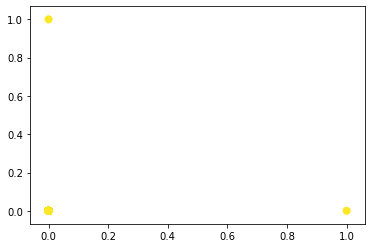

In [26]:
from sklearn.cluster import KMeans
from scipy import sparse

kmeans_pred= KMeans(n_clusters=4)
kmeans_pred.fit(features_pred)
y_kmeans_pred= kmeans_pred.predict(features_pred)
plt.scatter(features_pred[:, 0], features_pred[:, 1],  c=y_kmeans_pred, s=50, cmap='viridis')

In [27]:
keys= []
matrix= []
for key, vector in vector_dict.items():
    keys.append(key)
    matrix.append(vector)
    

In [28]:
features=np.vstack(matrix)
features.shape

(4560, 14859)

In [29]:
label2id={label:idx for idx, label in enumerate(keys)}
id2label={idx:label for idx, label in enumerate(keys)}

In [30]:
labels=np.asarray(keys)
labels.shape

(4560,)

In [31]:
from sklearn.cluster import KMeans
from scipy import sparse

kmeans= KMeans(n_clusters=4)
kmeans.fit(features)
y_kmeans= kmeans.predict(features)


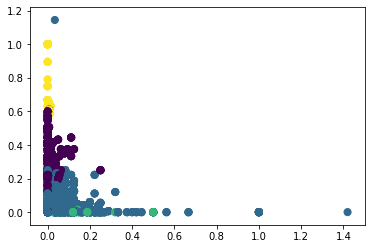

In [32]:
plt.scatter(features[:, 0], features[:, 1],  c=y_kmeans, s=50, cmap='viridis')

In [42]:
features_df = pd.DataFrame(features)
features_df = features_df.rename(columns= id2args)
features_df = features_df.rename(index= id2label)
features_df

,"(air iceland, ittoqqortoormiit)","(husserl, frege)","(equatorial guinea, in africa)","(belgians, kimbanguism)","(métal hurlant, syd mead)","(theron, north country)","(elizabeth ii, mann)","(abdul rashid dostum, islamic state of afghanistan)","(tikrit, persian gulf)","(jet propulsion laboratory, galileo)",...,"(atlantic ocean, cpr)","(fecb, kenya)","(broadway, ind eighth avenue line)","(canaan, jordan)","(english chess federation, fide)","(terry peck, falklands war)","(hero of the soviet union, zaytsev)","(nostalghia, prize of the ecumenical jury)","(thirtieth dynasty, pharaonic)","(columbus, franklinton)"
star-PER-MISC,0.001200,0.218400,0.001200,0.031200,0.031200,0.537600,0.050400,0.050400,0.001200,0.005200,...,0.000800,0.001200,0.001200,0.050400,0.000800,0.537600,0.031200,0.076800,0.050400,0.050400
star-PER-PER,0.001200,0.218400,0.001200,0.031200,0.031200,0.537600,0.050400,0.050400,0.001200,0.005200,...,0.000800,0.001200,0.001200,0.050400,0.000800,0.537600,0.031200,0.076800,0.050400,0.050400
star-ORG-PER,0.001200,0.218400,0.001200,0.031200,0.031200,0.537600,0.050400,0.050400,0.001200,0.005200,...,0.000800,0.001200,0.001200,0.050400,0.000800,0.537600,0.031200,0.076800,0.050400,0.050400
star-MISC-MISC,0.001200,0.218400,0.001200,0.031200,0.031200,0.537600,0.050400,0.050400,0.001200,0.005200,...,0.000800,0.001200,0.001200,0.050400,0.000800,0.537600,0.031200,0.076800,0.050400,0.050400
star-MISC-PER,0.001200,0.218400,0.001200,0.031200,0.031200,0.537600,0.050400,0.050400,0.001200,0.005200,...,0.000800,0.001200,0.001200,0.050400,0.000800,0.537600,0.031200,0.076800,0.050400,0.050400
star-LOC-MISC,0.001200,0.218400,0.001200,0.031200,0.031200,0.537600,0.050400,0.050400,0.001200,0.005200,...,0.000800,0.001200,0.001200,0.050400,0.000800,0.537600,0.031200,0.076800,0.050400,0.050400
star-PER-LOC,0.001200,0.218400,0.001200,0.031200,0.031200,0.537600,0.050400,0.050400,0.001200,0.005200,...,0.000800,0.001200,0.001200,0.050400,0.000800,0.537600,0.031200,0.076800,0.050400,0.050400
star-PER-ORG,0.001200,0.218400,0.001200,0.031200,0.031200,0.537600,0.050400,0.050400,0.001200,0.005200,...,0.000800,0.001200,0.001200,0.050400,0.000800,0.537600,0.031200,0.076800,0.050400,0.050400
be-ORG-ORG,0.045454,0.045223,0.187497,0.028136,0.028136,0.071994,0.121589,0.121589,0.187497,0.016906,...,0.067598,0.045454,0.187497,0.121589,1.016387,0.071994,0.028136,0.044792,0.121589,0.121589
be-LOC-MISC,0.045454,0.045223,0.187497,0.028136,0.028136,0.071994,0.121589,0.121589,0.187497,0.016906,...,0.067598,0.045454,0.187497,0.121589,0.016387,0.071994,0.028136,0.044792,0.121589,0.121589


In [43]:
features_df.describe()

,"(air iceland, ittoqqortoormiit)","(husserl, frege)","(equatorial guinea, in africa)","(belgians, kimbanguism)","(métal hurlant, syd mead)","(theron, north country)","(elizabeth ii, mann)","(abdul rashid dostum, islamic state of afghanistan)","(tikrit, persian gulf)","(jet propulsion laboratory, galileo)",...,"(atlantic ocean, cpr)","(fecb, kenya)","(broadway, ind eighth avenue line)","(canaan, jordan)","(english chess federation, fide)","(terry peck, falklands war)","(hero of the soviet union, zaytsev)","(nostalghia, prize of the ecumenical jury)","(thirtieth dynasty, pharaonic)","(columbus, franklinton)"
count,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000,...,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000,4560.000000
mean,0.050059,0.154887,0.088995,0.041977,0.041977,0.112880,0.118957,0.118957,0.088995,0.033344,...,0.027109,0.050059,0.088995,0.118957,0.038498,0.112880,0.041977,0.061516,0.118957,0.118957
std,0.097047,0.225791,0.166742,0.087661,0.087796,0.158108,0.160799,0.161089,0.167377,0.070790,...,0.064967,0.096644,0.166763,0.160855,0.104159,0.157947,0.088121,0.130463,0.160768,0.160912
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.017751,0.070312,0.026015,0.012346,0.012346,0.073225,0.079365,0.079365,0.026015,0.010000,...,0.002716,0.017751,0.026015,0.079365,0.004444,0.073225,0.012346,0.020408,0.079365,0.079365
75%,0.066236,0.205635,0.111111,0.050000,0.050000,0.147929,0.165680,0.165680,0.111111,0.041716,...,0.035167,0.066236,0.111111,0.165680,0.037037,0.147929,0.050000,0.064209,0.165680,0.165680
max,1.419660,1.143892,1.187497,1.122449,1.176550,1.200540,1.144033,1.357500,1.671296,1.040000,...,1.026311,1.241644,1.202938,1.185185,1.016387,1.084256,1.306509,1.119868,1.121589,1.227273


### Augmented data

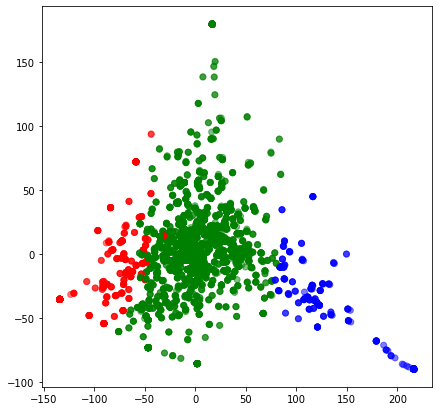

In [77]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(features)


pca = PCA(n_components=16)
x_7d = pca.fit_transform(X)

pca4 = PCA(n_components=4)
x_4d = pca.fit_transform(X)

#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 3)

#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_7d)

#Define our own color map
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(x_7d[:,0],x_7d[:,2], c= label_color, alpha=0.5, cmap='viridis') 
plt.show()



In [72]:
x_7d.shape, X_clustered.shape

((4560, 16), (4560,))

/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


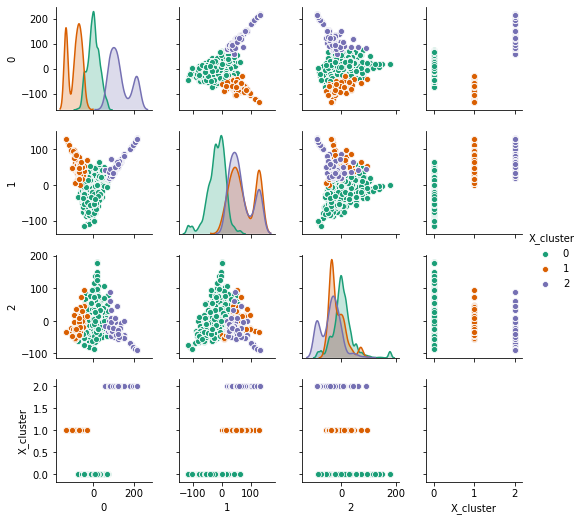

In [60]:
# Create a temp dataframe from our PCA projection data "x_9d"
df = pd.DataFrame(x_7d)
df = df[[0,1,2]] # only want to visualise relationships between first 3 projections
df['X_cluster'] = X_clustered

# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

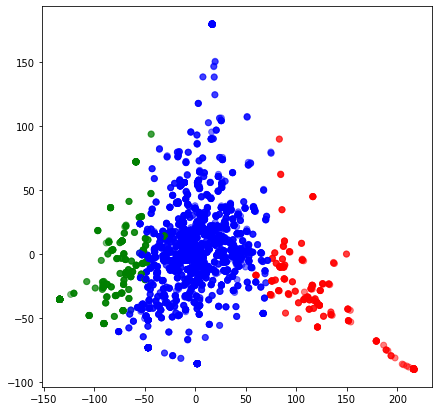

In [47]:
#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 3)

#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_4d)

#Define our own color map
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(x_4d[:,0],x_4d[:,2], c= label_color, alpha=0.5) 
plt.show()


In [48]:
# Create a temp dataframe from our PCA projection data "x_9d"
df = pd.DataFrame(x_4d)
df = df[[0,1,2]] # only want to visualise relationships between first 3 projections
df['X_cluster'] = X_clustered

/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


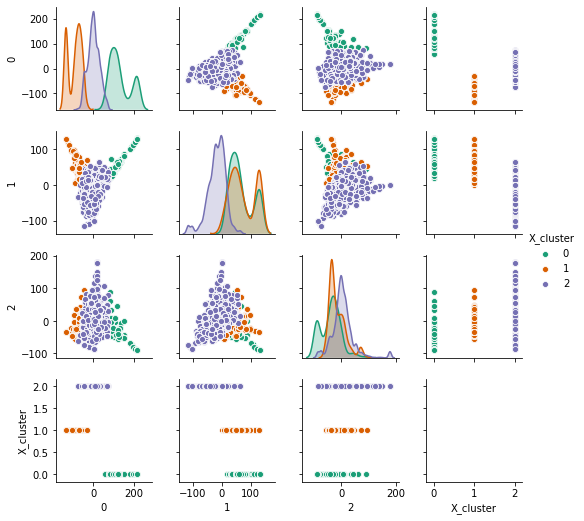

In [50]:
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

## no-typed data

In [52]:
features_df_pred = pd.DataFrame(features_pred)
features_df_pred = features_df_pred.rename(columns= id2args)
features_df_pred = features_df_pred.rename(index= id2label_pred)
features_df_pred

,"(air iceland, ittoqqortoormiit)","(husserl, frege)","(equatorial guinea, in africa)","(belgians, kimbanguism)","(métal hurlant, syd mead)","(theron, north country)","(elizabeth ii, mann)","(abdul rashid dostum, islamic state of afghanistan)","(tikrit, persian gulf)","(jet propulsion laboratory, galileo)",...,"(atlantic ocean, cpr)","(fecb, kenya)","(broadway, ind eighth avenue line)","(canaan, jordan)","(english chess federation, fide)","(terry peck, falklands war)","(hero of the soviet union, zaytsev)","(nostalghia, prize of the ecumenical jury)","(thirtieth dynasty, pharaonic)","(columbus, franklinton)"
star,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
be,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
appoint,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
established,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
carry,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
give,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
hold,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
express,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
have,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
consist,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


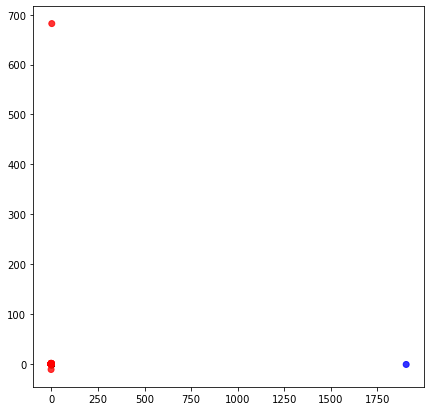

In [55]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X_pred = StandardScaler().fit_transform(features_pred)


pca = PCA(n_components=7)
x_7d = pca.fit_transform(X_pred)

pca4 = PCA(n_components=4)
x_4d = pca.fit_transform(X_pred)

#Set a 3 KMeans clustering
kmeans_pred = KMeans(n_clusters = 3)

#Compute cluster centers and predict cluster indices
X_clustered = kmeans_pred.fit_predict(x_7d)

#Define our own color map
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(x_7d[:,0],x_7d[:,2], c= label_color, alpha=0.8) 
plt.show()


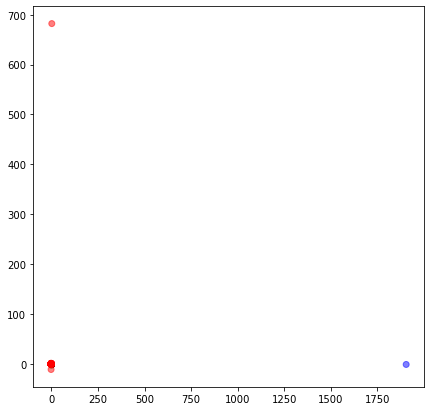

In [56]:
#Set a 3 KMeans clustering
kmeans = KMeans(n_clusters = 3)

#Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_4d)

#Define our own color map
LABEL_COLOR_MAP = {0:'r', 1: 'g', 2: 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(x_4d[:,0],x_4d[:,2], c= label_color, alpha=0.5) 
plt.show()


In [57]:


# Create a temp dataframe from our PCA projection data "x_9d"
df = pd.DataFrame(x_4d)
df = df[[0,1,2]] # only want to visualise relationships between first 3 projections
df['X_cluster'] = X_clustered


/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/yiyi/anaconda3/envs/semantik/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


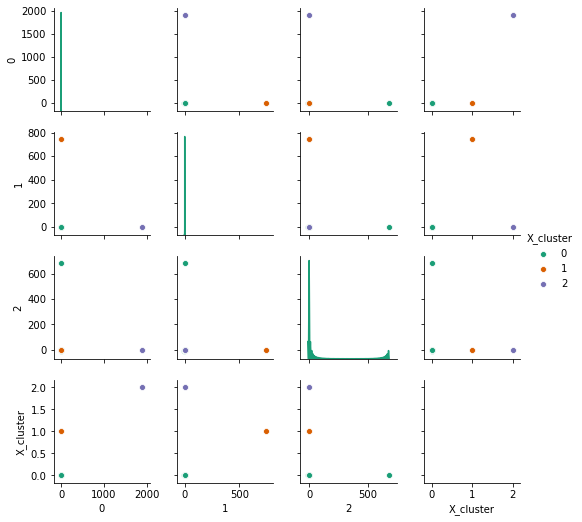

In [58]:
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)
